#### BERT based Sequence Labeller

We've explored training HMM (Viterbi) and RNN-based POS (part of speech) taggers on tagged sentences from the Stanford treebank dataset. We saw that the HMM tagger had a validation accuracy of about 90% and the RNN based tagger had about 91%. We will now try a different type of neural approach. For the RNN, recall that we used pretrained GloVe embeddings to represent the words in a sentence. Since the meaning of words in a sentence can be ambiguous, we should use contextualized vector representations of words instead of fixed GloVe word embeddings to overcome this problem of word sense. Pretrained BERT models are perfect for this task because they can be used to extract contextualized word embedding. 

In this notebook, we will finetune a BERT model on the POS tagging task. Since BERT uses subword tokenization and POS labels are assigned to whole words, we need to figure out a way of assigning labels to the subword tokens. A simple approach is to assign the POS label of a word to the first subword in the sequence of subwords corresponding to that word, then assign a special tag 'X' to the remaining subwords, which indicates a continuation of the preceding POS label. e.g.

`(spokesman, NN)` --> {`(spokes, NN)`, `(##man, X)`}



In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizerFast, RobertaModel, get_linear_schedule_with_warmup
from nltk.corpus import treebank
from tqdm import tqdm
import psutil

#### Set up the dataset.

Number of sentences:  3914
Longest sentence length: 271


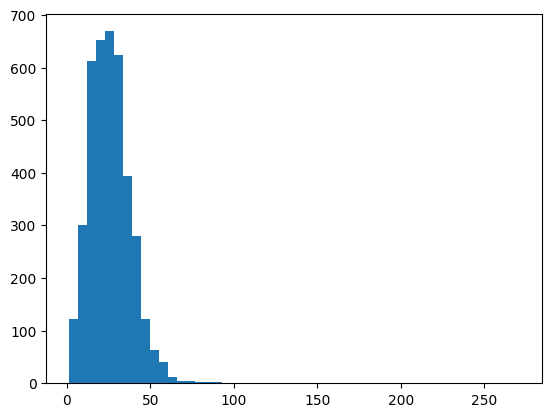

In [17]:
# get the POS tagged corpus, 3914 tagged sentences
corpus = treebank.tagged_sents()
print("Number of sentences: ", len(corpus))
print(f"Longest sentence length: {max([len(s) for s in corpus])}")

# create training-validation splits
num_train = int(0.9 * len(corpus))
train_corpus = corpus[:num_train]
val_corpus = corpus[num_train:]

# histogram of sent_lens
import matplotlib.pyplot as plt
sent_lens = [len(s) for s in corpus] 
plt.hist(sent_lens, bins=50)
plt.show()        

In [24]:
class Treebank(Dataset):
    def __init__(self, corpus, block_size=128):
        self.block_size = block_size
        # get the sentences and labels
        self.sentences = [[elem[0] for elem in s] for s in corpus]
        self.pos_labels = [[elem[1] for elem in s] for s in corpus]
        # define special tag
        self.continuation_tag = "X"
        # get tag set
        self.tags = sorted([self.continuation_tag] + list(set([elem[1] for s in corpus for elem in s])))
        # tag to idx mapping
        self.tag2idx = {tag: idx for idx, tag in enumerate(self.tags)}
        self.tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', add_prefix_space=True)

    @property
    def num_tags(self):
        return len(self.tags)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        # get sentence and labels
        sentence = self.sentences[idx]
        labels = self.pos_labels[idx]
        # tokenize the sentence
        input_encoding = self.tokenizer.encode_plus(sentence, is_split_into_words=True, return_offsets_mapping=False, padding=False, truncation=False, add_special_tokens=True)
        input_idx = input_encoding['input_ids']
        word_ids = input_encoding.word_ids()

        # truncate the input sequence if it is too long
        if len(input_idx) > self.block_size:
            input_idx = input_idx[:self.block_size-1] + input_idx[-1]
            word_ids = word_ids[:self.block_size-1] + word_ids[-1]
        word_ids = word_ids[1:-1]     

        # assign labels to subword tokens (we use -100 as label for special tokens)
        labels_subword = [-100]
        for i in range(len(word_ids)):
            if word_ids[i] != word_ids[i-1]:
                labels_subword.append(self.tag2idx[labels[word_ids[i]]])
            else:
                labels_subword.append(self.tag2idx["X"]) 
        labels_subword.append(-100)           

        # add padding 
        input_idx = input_idx + [self.tokenizer.pad_token_id] * (self.block_size - len(input_idx))    
        labels_subword = labels_subword + [-100] * (self.block_size - len(labels_subword))    
        # create attention mask 
        input_attn_mask = [1 if idx != self.tokenizer.pad_token_id else 0 for idx in input_idx]

        # convert to tensors
        input_idx = torch.tensor(input_idx)
        labels_subword = torch.tensor(labels_subword)
        input_attn_mask = torch.tensor(input_attn_mask) 
        
        return input_idx, labels_subword, input_attn_mask   

#### Create the POS tagger model

In [ ]:
class BERTPOS(torch.nn.Module):
    def __init__(self, num_classes, dropout_rate=0.1):
        super().__init__()
        # load pretrained BERT model
        #self.bert_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.bert_encoder = RobertaModel.from_pretrained('roberta-base')
        self.dropout = torch.nn.Dropout(dropout_rate)
        # define classifier head
        self.classifier_head = torch.nn.Linear(768, num_classes)
        # make sure BERT parameters are trainable
        for param in self.bert_encoder.parameters():
            param.requires_grad = True

    def forward(self, input_idx, input_attn_mask, targets=None):
        # compute BERT embeddings for input tokens
        bert_output = self.bert_encoder(input_idx, attention_mask=input_attn_mask)
        bert_output = self.dropout(bert_output.last_hidden_state) # shape: (batch_size, block_size, hidden_size)
        # compute output logits
        logits = self.classifier_head(bert_output) # shape: (batch_size, block_size, num_classes)
        # reshape logits to (batch_size * block_size, num_classes)
        logits = logits.view(-1, logits.shape[-1])
        # reshape targets to (batch_size * block_size)
        if targets is not None:
            targets = targets.view(-1)
        # compute cross-entropy loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits, targets, ignore_index=-100)
        return logits, loss

In [25]:
train_dataset = Treebank(train_corpus)
val_dataset = Treebank(val_corpus)